In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

# Data Preparation

In [2]:
digits = load_digits()
print(digits.keys())

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])


In [3]:
data = digits.data
images = digits.images
target = digits.target
target_names = digits.target_names

In [4]:
is_1_or_7 = np.isin(target, [1, 7])

data = data[is_1_or_7]
images = images[is_1_or_7]
target = target[is_1_or_7]


In [5]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.4, random_state=42)

## 1.1 Dimension Reduction

### 1.1.1 Remove Pixels with least standard deviation

In [6]:
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)

ones = X_train[y_train == 1]
sevens = X_train[y_train == 7]

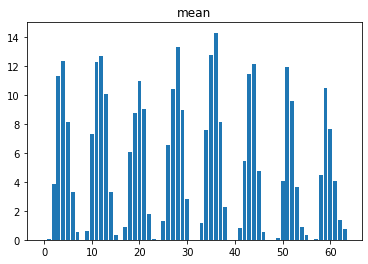

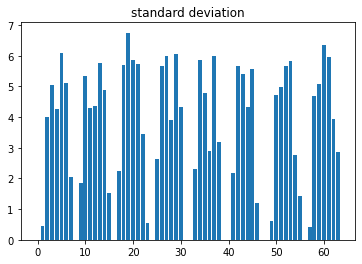

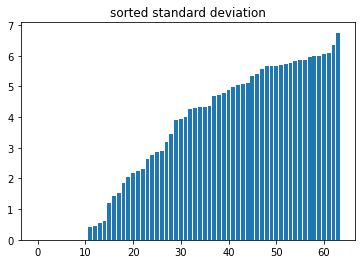

In [7]:
plt.bar(np.arange(64), mean)
plt.title("mean")
plt.show()

plt.bar(np.arange(64), std)
plt.title("standard deviation")
plt.show()

plt.bar(np.arange(64), np.sort(std))
plt.title("sorted standard deviation")
plt.show()

Some pixels have no/a very low standard deviation which means that they stay the same in nearly all images.

These carry very little information an can be eliminated.

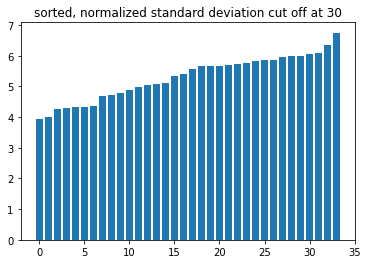

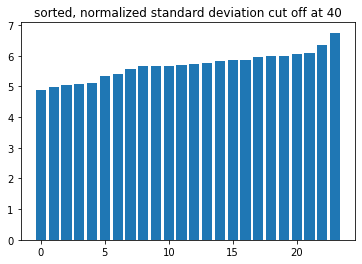

In [8]:
plt.bar(np.arange(34), np.sort(std)[30:])
plt.title("sorted, normalized standard deviation cut off at 30")
plt.show()

plt.bar(np.arange(24), np.sort(std)[40:])
plt.title("sorted, normalized standard deviation cut off at 40")
plt.show()

In [9]:
ones = X_train[:, std.argsort()[40:]][y_train == 1]
sevens = X_train[:, std.argsort()[40:]][y_train == 7]

### Create New Features

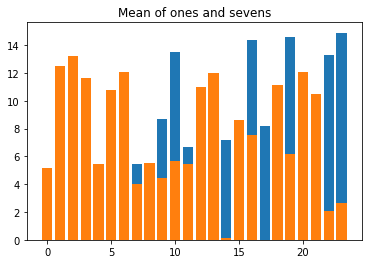

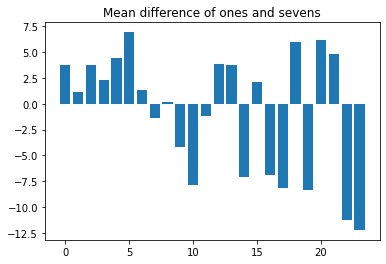

In [10]:
plt.bar(np.arange(24), ones.mean(axis=0))
plt.bar(np.arange(24), sevens.mean(axis=0))
plt.title("Mean of ones and sevens")
plt.show()


plt.bar(np.arange(24), sevens.mean(axis=0) - ones.mean(axis=0))
plt.title("Mean difference of ones and sevens")
plt.show()


Our two features will consist of weighted sums of the 24 pixel values with the highest derivation in the test data.

The weights of feature one will be the normalized average pixel value of the ones (blue bars), feature two the normalized average pixel value of the sevens (orange bars).

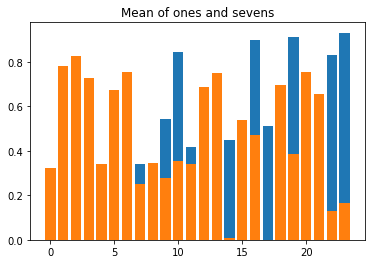

In [11]:
ones_mean = ones.mean(axis=0) / X_train.max()
sevens_mean = sevens.mean(axis=0) / X_train.max()

plt.bar(np.arange(24), ones_mean)
plt.bar(np.arange(24), sevens_mean)
plt.title("Mean of ones and sevens")
plt.show()

In [12]:
def reduce_dim(X):
    X_filtered = X[:, std.argsort()[40:]]
    feat_1 =  X_filtered.dot(ones_mean)
    feat_2 = X_filtered.dot(sevens_mean)
    return np.vstack([feat_1, feat_2]).transpose()

In [13]:
X_train_reduced = reduce_dim(X_train)
X_test_reduced = reduce_dim(X_test)

## 1.2 Scatterplot

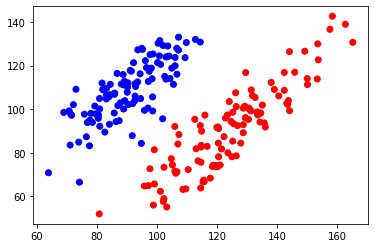

In [14]:
plt.scatter(*X_train_reduced.transpose(), c=["r" if x == 1 else "b" for x in y_train])
plt.show()

This looks promising :)

# 2 Nearest Mean

## 2.1 Nearest Mean Classifier

In [15]:
np.vstack([X_train_reduced[y_train == 1].mean(axis=0), 
                       X_train_reduced[y_train == 7].mean(axis=0)])

array([[124.20753494,  90.59498242],
       [ 90.59498242, 108.70457176]])

In [16]:
def nearest_mean(training_features, training_labels, test_features):
    labels = np.unique(training_labels)
    means = np.array([training_features[y_train == label].mean(axis=0)
                          for label in labels])
    distances = np.linalg.norm(test_features - means[:, None, :], axis=2, ord=2)

    return labels[np.argmin(distances, axis=0)]

In [17]:
predicted_labels = nearest_mean(X_train_reduced, y_train, X_test_reduced)

In [18]:
print("error", 100 * sum(predicted_labels != y_test) / len(y_test), "%")

error 1.3793103448275863 %


### 2.2 Visualize Decision Regions

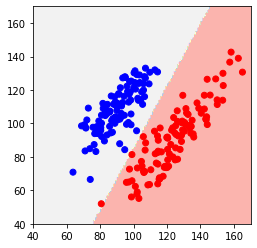

In [19]:
range_start = 40
range_end = 170
range_len = range_end - range_start

grid = np.dstack(np.meshgrid(np.arange(range_start, range_end), np.arange(range_start, range_end))).reshape(-1, 2)
predictions = nearest_mean(X_train_reduced, y_train, grid).reshape(range_len, range_len)

plt.imshow(predictions, origin="lower", extent=[range_start, range_end, range_start, range_end], cmap="Pastel1")
plt.scatter(*X_train_reduced.transpose(), c=["r" if x == 1 else "b" for x in y_train])
plt.show()

# 3. QDA

## 3.1 QDA Training

In [20]:
def fit_qda(training_features, training_labels):
    label1, label2 = np.unique(training_labels)
    
    X_1, X_2 = training_features[training_labels == label1], training_features[training_labels == label2]
    
    mean = np.array([
        X_1.mean(axis=0), 
        X_2.mean(axis=0)
    ])
    
    cov = np.array([
        (X_1 - mean[0]).transpose().dot((X_1 - mean[0])) / len(X_1),
        (X_2 - mean[1]).transpose().dot((X_2 - mean[1])) / len(X_2),
    ])
    
    p = np.array([
        len(X_1) / len(training_features),
        len(X_2) / len(training_features)
    ])
        
    return mean, cov, p

In [21]:
mu, covmat, p = fit_qda(X_train_reduced, y_train)

## 3.2 QDA Prediction

### TODO vectorize this

In [22]:
def b_k(cov, p):
    return np.log(np.sqrt(np.linalg.det(2 * np.pi * covmat))) - np.log(p)

In [23]:
def predict_qda(mu, covmat, p, test_features):
    return np.array([np.argmin([0.5 * (x_i - mu[k]).dot(np.linalg.inv(covmat[k])).dot((x_i - mu[k])) + b_k(covmat, p)[k] for k in [0, 1]])
               for x_i in test_features])

In [24]:
np.array([1, 7])[predict_qda(*fit_qda(X_train_reduced, y_train), X_test_reduced)] == y_test

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

## 3.3 Visualization

In [25]:
def multivariate_normal(x, d, mean, covariance):
    """pdf of the multivariate normal distribution.
    Taken from https://peterroelants.github.io/posts/multivariate-normal-primer/
    """
    x_m = x - mean
    return (1. / (np.sqrt((2 * np.pi)**d * np.linalg.det(covariance))) * 
            np.exp(-(np.linalg.solve(covariance, x_m).T.dot(x_m)) / 2)) 

In [26]:
np.vectorize(lambda x: multivariate_normal(x, d=2, mean=mu[0], covariance=covmat[0]))(grid[:3])

array([[1.39894197e-13, 1.39894197e-13],
       [1.98058818e-13, 1.39894197e-13],
       [2.79331002e-13, 1.39894197e-13]])

TypeError: Input z must be 2D, not 1D

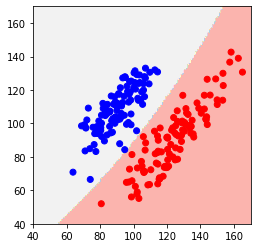

In [35]:
range_start = 40
range_end = 170
range_len = range_end - range_start
the_range = np.arange(range_start, range_end)


X, Y = np.meshgrid(np.arange(range_start, range_end), np.arange(range_start, range_end))
grid = np.dstack((X, Y)).reshape(-1, 2)
predictions = predict_qda(*fit_qda(X_train_reduced, y_train), grid).reshape(range_len, range_len)

plt.imshow(predictions, origin="lower", extent=[range_start, range_end, range_start, range_end], cmap="Pastel1")
plt.scatter(*X_train_reduced.transpose(), c=["r" if x == 1 else "b" for x in y_train])

rv = multivariate_normal([0, 1], [[1, 0.8], [0.8, 1]])
Z = rv.pdf(grid)
plt.contour(X, Y, Z)
plt.show() 

Sooo, there is no misclassification here. Maybe our data preparation was a bit too clever... ups

In [46]:
from scipy.stats import multivariate_normal

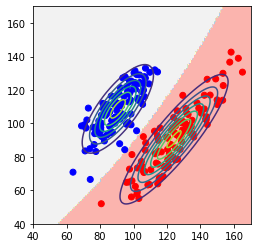

In [45]:
range_start = 40
range_end = 170
range_len = range_end - range_start
the_range = np.arange(range_start, range_end)

X, Y = np.meshgrid(the_range, the_range)
grid  = np.dstack((X, Y))


plt.imshow(predictions, origin="lower", extent=[range_start, range_end, range_start, range_end], cmap="Pastel1")
plt.scatter(*X_train_reduced.transpose(), c=["r" if x == 1 else "b" for x in y_train])

plt.contour(X, Y, multivariate_normal(mu[0], covmat[0]).pdf(grid))
plt.contour(X, Y, multivariate_normal(mu[1], covmat[1]).pdf(grid))

plt.show()